In [1]:
# Import the necessary libraries.
# Since we are using Python, import the SparkSession and related functions
# from the PySpark module.
#import findspark
#findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import count

In [2]:
# Build a SparkSession using the SparkSession APIs.
# If one does not exist, then create an instance. There
# can only be one SparkSession per JVM.
spark = (SparkSession
.builder
.appName("DataFrame")
.getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/02 18:53:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/06/02 18:53:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
sc = spark.sparkContext

##### we want to aggregate all the ages for each name, group by 
###### name, and then average the ages

#### Using RDD

In [4]:
# In Python
# Create an RDD of tuples (name, age)
dataRDD = sc.parallelize([("Brooke", 20), ("Denny", 31), ("Jules", 30),
("TD", 35), ("Brooke", 25),("Jules", 40), ("Denny", 51)])

In [5]:
dataRDD.first()

('Brooke', 20)

In [6]:
dataRDD.take(2)

[('Brooke', 20), ('Denny', 31)]

In [7]:
# Use map and reduceByKey transformations with their lambda
# expressions to aggregate and then compute average

In [8]:
#Step 1
s1 = dataRDD.map(lambda x : (x[0],(x[1],1)))
s1.take(2)

[('Brooke', (20, 1)), ('Denny', (31, 1))]

In [9]:
#Step 2
s2 = s1.reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1]))
s2.take(2)

[('Denny', (82, 2)), ('TD', (35, 1))]

In [10]:
s2.collect()

[('Denny', (82, 2)), ('TD', (35, 1)), ('Brooke', (45, 2)), ('Jules', (70, 2))]

In [11]:
#Step 3
s3 = s2.map(lambda x : (x[0],x[1][0]/x[1][1]))

In [12]:
s3.collect()

[('Denny', 41.0), ('TD', 35.0), ('Brooke', 22.5), ('Jules', 35.0)]

In [13]:
agesRDD = (dataRDD
.map(lambda x: (x[0], (x[1], 1)))
.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
.map(lambda x: (x[0], x[1][0]/x[1][1])))

In [14]:
agesRDD.collect()

[('Denny', 41.0), ('TD', 35.0), ('Brooke', 22.5), ('Jules', 35.0)]

No one would dispute that this code, which tells Spark how to aggregate keys and
compute averages with a string of lambda functions, is cryptic and hard to read. In
other words, the code is instructing Spark <b>how to compute the query</b>. It’s completely
opaque to Spark, because it doesn’t communicate the intention. Furthermore, the
equivalent RDD code in Scala would look very different from the Python code shown
here.

By contrast, what if we were to express the same query with high-level DSL operators
and the DataFrame API, thereby instructing Spark <b>what to do?</b>

#### Using DataFrame

In [15]:
from pyspark.sql.functions import avg

In [16]:
# Create a DataFrame
data_df = spark.createDataFrame([("Brooke", 20), ("Denny", 31), ("Jules", 30),
("TD", 35), ("Brooke", 25),("Jules", 40), ("Denny", 51)],['name','age'])

In [17]:
data_df

DataFrame[name: string, age: bigint]

In [18]:
data_df.show()

+------+---+
|  name|age|
+------+---+
|Brooke| 20|
| Denny| 31|
| Jules| 30|
|    TD| 35|
|Brooke| 25|
| Jules| 40|
| Denny| 51|
+------+---+



In [19]:
data_df.collect()

[Row(name='Brooke', age=20),
 Row(name='Denny', age=31),
 Row(name='Jules', age=30),
 Row(name='TD', age=35),
 Row(name='Brooke', age=25),
 Row(name='Jules', age=40),
 Row(name='Denny', age=51)]

In [20]:
df = data_df.collect()

In [21]:
df[0]

Row(name='Brooke', age=20)

In [22]:
df[0][1]

20

In [23]:
df[0].name

'Brooke'

In [24]:
df[0].age

20

In [25]:
# Group the same names together, aggregate their ages, and compute an average
avg_df = data_df.groupBy('name').agg(avg('age'))

In [26]:
avg_df

DataFrame[name: string, avg(age): double]

In [27]:
avg_df.show()

+------+--------+
|  name|avg(age)|
+------+--------+
|Brooke|    22.5|
| Denny|    41.0|
| Jules|    35.0|
|    TD|    35.0|
+------+--------+



In [28]:
avg_df = data_df.groupBy('name').agg(avg('age').alias('Average'))

In [29]:
avg_df.show()

+------+-------+
|  name|Average|
+------+-------+
|Brooke|   22.5|
| Denny|   41.0|
| Jules|   35.0|
|    TD|   35.0|
+------+-------+



##### Because Spark can inspect or parse this query and understand our intention, it can optimize or arrange the operations for efficient execution.

Inspired by pandas DataFrames in structure, format, and a few specific operations,
Spark DataFrames are like distributed in-memory tables with named columns and
schemas, where each column has a specific data type: integer, string, array, map, real,
date, timestamp, etc.

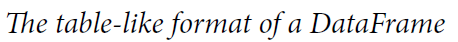
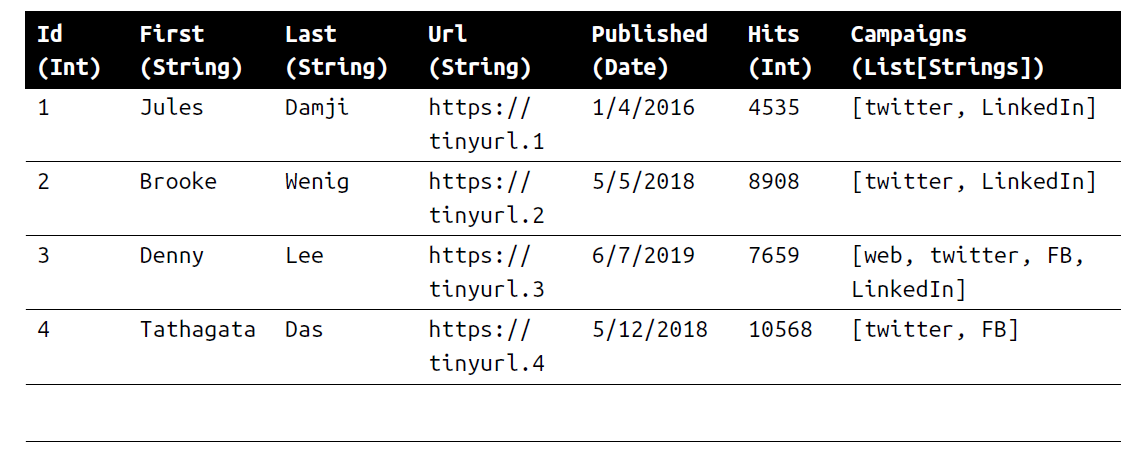

When data is visualized as a structured table, it’s not only easy to digest but also easy
to work with when it comes to common operations you might want to execute on
rows and columns.

## Datasets and DataFrames
<ul>
    <li>A Dataset is a distributed collection of data. Dataset is a new interface added in Spark 1.6 that provides the benefits of RDDs (strong typing, ability to use powerful lambda functions) with the benefits of Spark SQL’s optimized execution engine</li>
    <li>The Dataset API is available in Scala and Java. Python does not have the support for the Dataset API. But due to Python’s dynamic nature, many of the benefits of the Dataset API are already available (i.e. you can access the field of a row by name naturally row.columnName).</li>
    <li>A DataFrame is a Dataset organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python, but with richer optimizations under the hood.</li>
    <li>DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.</li>
    <li>The DataFrame API is available in Scala, Java, Python, and R. </li>    
</ul>

#### DataFrames are immutable and Spark keeps a lineage of all transformations.
You can add or change
the names and data types of the columns, creating new DataFrames while the previous
versions are preserved.

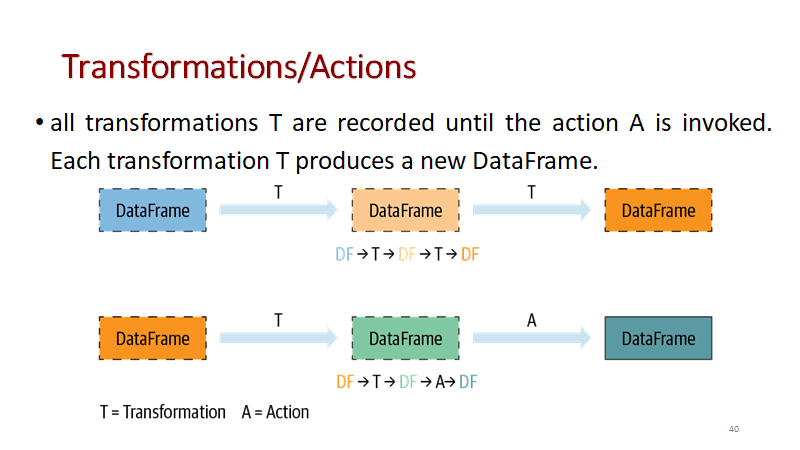

#### A named column in a DataFrame and its associated Spark data type can be declared in the schema.

## Spark’s Basic Data Types

Matching its supported programming languages, Spark supports basic internal data
types. These data types can be declared in your Spark application or defined in your
schema.
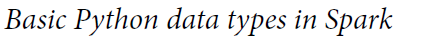
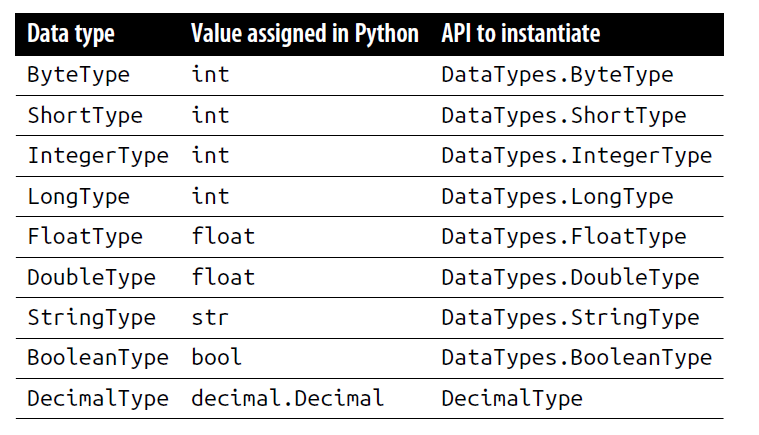

## Spark’s Structured and Complex Data Types

For complex data analytics, you won’t deal only with simple or basic data types. Your
data will be complex, often structured or nested, and you’ll need Spark to handle
these complex data types. They come in many forms: <b>maps, arrays, structs, dates,
timestamps, fields, etc.</b>
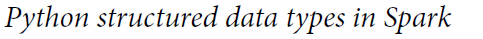
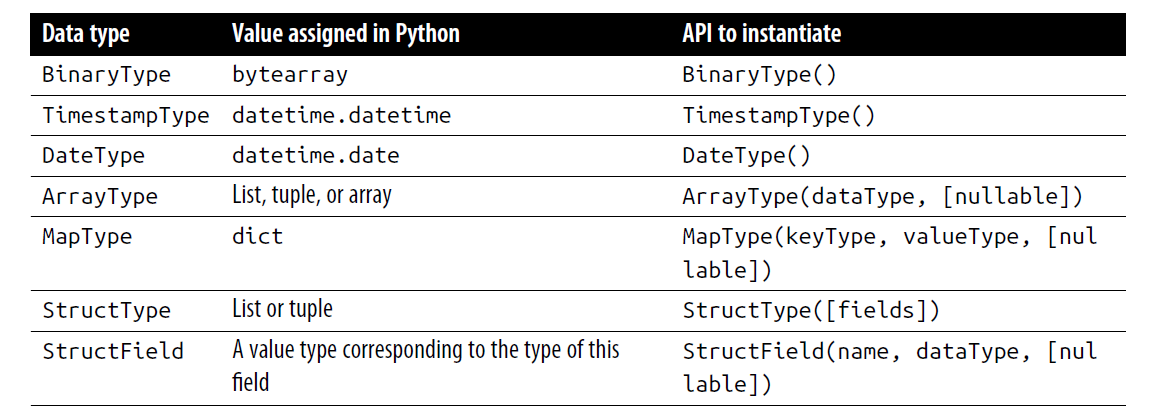

<I><b><font color='red'>Note:</font> While these tables showcase the myriad types supported, it’s far more important to
see how these types come together when you define a schema for your data.</b></I>

## Creating DataFrames

In [30]:
# spark is an existing SparkSession
df = spark.read.json("people.json")
# Displays the content of the DataFrame to stdout
df.show()

+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+



In [31]:
df.printSchema()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



## DataFrame Operations

In Python, it’s possible to access a DataFrame’s columns either by attribute <b>(df.age)</b> or by indexing <b>(df['age'])</b>. While the former is convenient for interactive data exploration, users are highly encouraged to use the latter form, which is future proof and won’t break with column names that are also attributes on the DataFrame class.

In [32]:
from pyspark.sql.functions import col

In [33]:
df.age

Column<'age'>

In [34]:
df['age']

Column<'age'>

In [35]:
col('age')

Column<'age'>

In [36]:
# can cause error if you generate wrong column name
col('adssdd')

Column<'adssdd'>

In [37]:
# spark, df are from the previous example
# Print the schema in a tree format
df.printSchema()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



In [38]:
# Select only the "name" column
df.select('name').show()

+-------+
|   name|
+-------+
|Michael|
|   Andy|
| Justin|
+-------+



In [39]:
# Select everybody, but increment the age by 1
df.select(df['name'],df['age'] + 1).show()

+-------+---------+
|   name|(age + 1)|
+-------+---------+
|Michael|     null|
|   Andy|       31|
| Justin|       20|
+-------+---------+



In [40]:
df.select(df['name'],(df['age'] + 1).alias('New Age')).show()

+-------+-------+
|   name|New Age|
+-------+-------+
|Michael|   null|
|   Andy|     31|
| Justin|     20|
+-------+-------+



In [41]:
df.filter(df['age']>21).show()

+---+----+
|age|name|
+---+----+
| 30|Andy|
+---+----+



In [42]:
# Count people by age
df.groupBy('name').count().show()

+-------+-----+
|   name|count|
+-------+-----+
|Michael|    1|
|   Andy|    1|
| Justin|    1|
+-------+-----+



In [43]:
df.groupBy('name').avg().show()

+-------+--------+
|   name|avg(age)|
+-------+--------+
|Michael|    null|
|   Andy|    30.0|
| Justin|    19.0|
+-------+--------+



In [44]:
df.groupBy('name').agg(avg('age').alias('Average')).show()

+-------+-------+
|   name|Average|
+-------+-------+
|Michael|   null|
|   Andy|   30.0|
| Justin|   19.0|
+-------+-------+



## Grouping Data

PySpark DataFrame also provides a way of handling grouped data by using the common approach, split-apply-combine strategy.
It groups the data by a certain condition applies a function to each group and then combines them back to the DataFrame.

In [45]:
df = spark.createDataFrame([
    ['red', 'banana', 1, 10], ['blue', 'banana', 2, 20], ['red', 'carrot', 3, 30],
    ['blue', 'grape', 4, 40], ['red', 'carrot', 5, 50], ['black', 'carrot', 6, 60],
    ['red', 'banana', 7, 70], ['red', 'grape', 8, 80]], schema=['color', 'fruit', 'v1', 'v2'])
df.show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
|  red|banana|  1| 10|
| blue|banana|  2| 20|
|  red|carrot|  3| 30|
| blue| grape|  4| 40|
|  red|carrot|  5| 50|
|black|carrot|  6| 60|
|  red|banana|  7| 70|
|  red| grape|  8| 80|
+-----+------+---+---+



In [46]:
df.groupBy('color')

In [47]:
df.groupBy('color').show()

AttributeError: 'GroupedData' object has no attribute 'show'

In [ ]:
df.groupBy('color').avg()

In [48]:
df.groupBy('color').avg().show()

+-----+-------+-------+
|color|avg(v1)|avg(v2)|
+-----+-------+-------+
|  red|    4.8|   48.0|
| blue|    3.0|   30.0|
|black|    6.0|   60.0|
+-----+-------+-------+



In [49]:
df.groupBy('color').avg('v1').show()

+-----+-------+
|color|avg(v1)|
+-----+-------+
|  red|    4.8|
| blue|    3.0|
|black|    6.0|
+-----+-------+



In [50]:
df.groupBy('color').avg('v1','v2').show()

+-----+-------+-------+
|color|avg(v1)|avg(v2)|
+-----+-------+-------+
|  red|    4.8|   48.0|
| blue|    3.0|   30.0|
|black|    6.0|   60.0|
+-----+-------+-------+



In [51]:
from pyspark.sql.functions import avg

In [52]:
df.groupBy('color').agg(avg('v1'),avg('v2')).show()

+-----+-------+-------+
|color|avg(v1)|avg(v2)|
+-----+-------+-------+
|  red|    4.8|   48.0|
| blue|    3.0|   30.0|
|black|    6.0|   60.0|
+-----+-------+-------+



In [53]:
df.groupBy('color').agg(avg('v1').alias('Average v1'),avg('v2').alias('Average v2')).show()

+-----+----------+----------+
|color|Average v1|Average v2|
+-----+----------+----------+
|  red|       4.8|      48.0|
| blue|       3.0|      30.0|
|black|       6.0|      60.0|
+-----+----------+----------+



In [54]:
df.groupBy('color').agg(avg('v1').alias('Average v1'),
                        avg('v2').alias('Average v2')).sort('Average v1').show()

+-----+----------+----------+
|color|Average v1|Average v2|
+-----+----------+----------+
| blue|       3.0|      30.0|
|  red|       4.8|      48.0|
|black|       6.0|      60.0|
+-----+----------+----------+



In [55]:
df.groupBy('color').agg(avg('v1').alias('Average v1'),
                        avg('v2').alias('Average v2')).sort('color').show()

+-----+----------+----------+
|color|Average v1|Average v2|
+-----+----------+----------+
|black|       6.0|      60.0|
| blue|       3.0|      30.0|
|  red|       4.8|      48.0|
+-----+----------+----------+



In [56]:
df.groupBy('color').agg(avg('v1').alias('Average v1'),
                        avg('v2').alias('Average v2')).sort('Average v1','Average v2').show()

+-----+----------+----------+
|color|Average v1|Average v2|
+-----+----------+----------+
| blue|       3.0|      30.0|
|  red|       4.8|      48.0|
|black|       6.0|      60.0|
+-----+----------+----------+



In [57]:
df.show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
|  red|banana|  1| 10|
| blue|banana|  2| 20|
|  red|carrot|  3| 30|
| blue| grape|  4| 40|
|  red|carrot|  5| 50|
|black|carrot|  6| 60|
|  red|banana|  7| 70|
|  red| grape|  8| 80|
+-----+------+---+---+



In [58]:
df.sort('fruit').show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
| blue|banana|  2| 20|
|  red|banana|  1| 10|
|  red|banana|  7| 70|
|  red|carrot|  3| 30|
|black|carrot|  6| 60|
|  red|carrot|  5| 50|
|  red| grape|  8| 80|
| blue| grape|  4| 40|
+-----+------+---+---+



In [59]:
df.sort('fruit','v1').show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
|  red|banana|  1| 10|
| blue|banana|  2| 20|
|  red|banana|  7| 70|
|  red|carrot|  3| 30|
|  red|carrot|  5| 50|
|black|carrot|  6| 60|
| blue| grape|  4| 40|
|  red| grape|  8| 80|
+-----+------+---+---+



In [60]:
df.sort('color','fruit','v1').show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
|black|carrot|  6| 60|
| blue|banana|  2| 20|
| blue| grape|  4| 40|
|  red|banana|  1| 10|
|  red|banana|  7| 70|
|  red|carrot|  3| 30|
|  red|carrot|  5| 50|
|  red| grape|  8| 80|
+-----+------+---+---+



In [61]:
df.groupby('color').count().show()

+-----+-----+
|color|count|
+-----+-----+
|  red|    5|
| blue|    2|
|black|    1|
+-----+-----+



In [62]:
df.groupby(['color','fruit']).avg().show()

+-----+------+-------+-------+
|color| fruit|avg(v1)|avg(v2)|
+-----+------+-------+-------+
|  red|banana|    4.0|   40.0|
| blue|banana|    2.0|   20.0|
|  red|carrot|    4.0|   40.0|
| blue| grape|    4.0|   40.0|
|black|carrot|    6.0|   60.0|
|  red| grape|    8.0|   80.0|
+-----+------+-------+-------+



In [63]:
df.groupby('color').count().show()

+-----+-----+
|color|count|
+-----+-----+
|  red|    5|
| blue|    2|
|black|    1|
+-----+-----+



In [64]:
df.groupby(['color','fruit']).avg('v1').show()
df.groupby('color').avg('v2').show()

+-----+------+-------+
|color| fruit|avg(v1)|
+-----+------+-------+
|  red|banana|    4.0|
| blue|banana|    2.0|
|  red|carrot|    4.0|
| blue| grape|    4.0|
|black|carrot|    6.0|
|  red| grape|    8.0|
+-----+------+-------+

+-----+-------+
|color|avg(v2)|
+-----+-------+
|  red|   48.0|
| blue|   30.0|
|black|   60.0|
+-----+-------+



In [65]:
df.groupby(['color','fruit']).agg(avg('v1').alias('v1_avg')).show()
df.groupby('color').agg(avg('v2').alias('v2_avg')).show()

+-----+------+------+
|color| fruit|v1_avg|
+-----+------+------+
|  red|banana|   4.0|
| blue|banana|   2.0|
|  red|carrot|   4.0|
| blue| grape|   4.0|
|black|carrot|   6.0|
|  red| grape|   8.0|
+-----+------+------+

+-----+------+
|color|v2_avg|
+-----+------+
|  red|  48.0|
| blue|  30.0|
|black|  60.0|
+-----+------+



## Schemas and Creating DataFrames

A schema in Spark defines the column names and associated data types for a DataFrame. Most often, schemas come into play when you are reading structured data
from an external data source Defining a schema
up front as opposed to taking a schema-on-read approach offers three benefits:
<b>
1. You relieve Spark from the onus of inferring data types.
2. You prevent Spark from creating a separate job just to read a large portion of your file to ascertain the schema, which for a large data file can be expensive and time-consuming.
3. You can detect errors early if data doesn’t match the schema.
</b>

<i>So, it is encouraged to always define your schema up front whenever you want to
read a large file from a data source.</i>

### Two ways to define a schema
Spark allows you to define a schema in two ways. <b>One is to define it programmatically</b>,
and the other is to <b>employ a Data Definition Language (DDL) string</b>, which is
much simpler and easier to read.

<b>To define a schema programmatically for a DataFrame with three named columns,
author, title, and pages, you can use the Spark DataFrame API. <i>For example:</i></b>

In [66]:
from pyspark.sql.types import *

In [67]:
schema = StructType([StructField('author',StringType(),False),
                    StructField("title", StringType(), False),
                    StructField("pages", IntegerType(), False)])

<b>Defining the same schema using DDL is much simpler:</b>

In [68]:
# Define schema for our data using DDL
# we are using back quote (`Id`) to define column name
schema = "`Id` INT, `First` STRING, `Last` STRING, `Url` STRING,`Published` STRING, `Hits` INT, `Campaigns` ARRAY<STRING>"

In [69]:
data = [[1, "Jules", "Damji", "https://tinyurl.1", "1/4/2016", 4535, ["twitter","LinkedIn"]],
[2, "Brooke","Wenig", "https://tinyurl.2", "5/5/2018", 8908, ["twitter","LinkedIn"]],
[3, "Denny", "Lee", "https://tinyurl.3", "6/7/2019", 7659, ["web","twitter", "FB", "LinkedIn"]],
[4, "Tathagata", "Das", "https://tinyurl.4", "5/12/2018", 10568,["twitter", "FB"]],
[5, "Matei","Zaharia", "https://tinyurl.5", "5/14/2014", 40578, ["web","twitter", "FB", "LinkedIn"]],
[6, "Reynold", "Xin", "https://tinyurl.6", "3/2/2015", 25568,["twitter", "LinkedIn"]]]

In [70]:
# Written blogs by authors and advertised on social media.

# Create a DataFrame using the schema defined above
blogs_df = spark.createDataFrame(data, schema)
# Show the DataFrame; it should reflect our table above
blogs_df.show()
# Print the schema used by Spark to process the DataFrame
print(blogs_df.printSchema())

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+

root
 |-- Id: integer (nullable = true)
 |-- First: string (nullable = true)
 |-- Last: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Published: string (nullable = true)
 |-- Hits: integer (

In [71]:
# Create a DataFrame without using the schema 
blogs_df_2 = spark.createDataFrame(data)
# Show the DataFrame; it should reflect our table above
blogs_df_2.show()
# Print the schema used by Spark to process the DataFrame
print(blogs_df_2.printSchema())

+---+---------+-------+-----------------+---------+-----+--------------------+
| _1|       _2|     _3|               _4|       _5|   _6|                  _7|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+

root
 |-- _1: long (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: string (nullable = true)
 |-- _4: string (nullable = true)
 |-- _5: string (nullable = true)
 |-- _6: long (nullable = true)
 |--

In [72]:
# Create a DataFrame without using the schema 
blogs_df_3 = spark.createDataFrame(data,['Id', 'First', 'Last', 'Url','Published', 'Hits', 'Campaigns'])
# Show the DataFrame; it should reflect our table above
blogs_df_3.show()
# Print the schema used by Spark to process the DataFrame
print(blogs_df_3.printSchema())

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+

root
 |-- Id: long (nullable = true)
 |-- First: string (nullable = true)
 |-- Last: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Published: string (nullable = true)
 |-- Hits: long (nullab

In [73]:
# We can get the schema definition and use it anywhere
blogs_df.schema

StructType(List(StructField(Id,IntegerType,true),StructField(First,StringType,true),StructField(Last,StringType,true),StructField(Url,StringType,true),StructField(Published,StringType,true),StructField(Hits,IntegerType,true),StructField(Campaigns,ArrayType(StringType,true),true)))

In [74]:
blogs_df.columns

['Id', 'First', 'Last', 'Url', 'Published', 'Hits', 'Campaigns']

In [75]:
blogs_df['Hits']

Column<'Hits'>

In [76]:
blogs_df.select('Hits').show()

+-----+
| Hits|
+-----+
| 4535|
| 8908|
| 7659|
|10568|
|40578|
|25568|
+-----+



In [77]:
blogs_df.select('Hits').show(3)

+----+
|Hits|
+----+
|4535|
|8908|
|7659|
+----+
only showing top 3 rows



In [78]:
blogs_df.select('Hits').head(3)

[Row(Hits=4535), Row(Hits=8908), Row(Hits=7659)]

In [79]:
blogs_df.select(blogs_df['Hits']*2).show()

+----------+
|(Hits * 2)|
+----------+
|      9070|
|     17816|
|     15318|
|     21136|
|     81156|
|     51136|
+----------+



In [80]:
blogs_df.select((blogs_df['Hits']*2).alias('Double Hits')).show()

+-----------+
|Double Hits|
+-----------+
|       9070|
|      17816|
|      15318|
|      21136|
|      81156|
|      51136|
+-----------+



In [81]:
from pyspark.sql.functions import expr

In [82]:
blogs_df.select(expr('Hits * 2')).show()

+----------+
|(Hits * 2)|
+----------+
|      9070|
|     17816|
|     15318|
|     21136|
|     81156|
|     51136|
+----------+



In [83]:
blogs_df.select(expr('Hits * 2').alias('Double Hits')).show()

+-----------+
|Double Hits|
+-----------+
|       9070|
|      17816|
|      15318|
|      21136|
|      81156|
|      51136|
+-----------+



In [84]:
blogs_df.select('Hits',expr('Hits * 2').alias('Double Hits')).show()

+-----+-----------+
| Hits|Double Hits|
+-----+-----------+
| 4535|       9070|
| 8908|      17816|
| 7659|      15318|
|10568|      21136|
|40578|      81156|
|25568|      51136|
+-----+-----------+



In [146]:
blogs_df.select('Hits * 2')

AnalysisException: cannot resolve '`Hits * 2`' given input columns: [Campaigns, First, Hits, Id, Last, Published, Url];
'Project ['Hits * 2]
+- LogicalRDD [Id#748, First#749, Last#750, Url#751, Published#752, Hits#753, Campaigns#754], false


In [147]:
blogs_df.select('Hits').show()

+-----+
| Hits|
+-----+
| 4535|
| 8908|
| 7659|
|10568|
|40578|
|25568|
+-----+



In [148]:
blogs_df.select('Hits','First').show()

+-----+---------+
| Hits|    First|
+-----+---------+
| 4535|    Jules|
| 8908|   Brooke|
| 7659|    Denny|
|10568|Tathagata|
|40578|    Matei|
|25568|  Reynold|
+-----+---------+



In [86]:
from pyspark.sql.functions import col

In [87]:
blogs_df.select((col("Hits") * 2)).show()

+----------+
|(Hits * 2)|
+----------+
|      9070|
|     17816|
|     15318|
|     21136|
|     81156|
|     51136|
+----------+



In [88]:
blogs_df.select((col("Hits") * 2).alias('Double Hits')).show()

+-----------+
|Double Hits|
+-----------+
|       9070|
|      17816|
|      15318|
|      21136|
|      81156|
|      51136|
+-----------+



In [89]:
# Creating New Column
blogs_df.withColumn('Big Hitters',col('Hits')>10000).show()

+---+---------+-------+-----------------+---------+-----+--------------------+-----------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|Big Hitters|
+---+---------+-------+-----------------+---------+-----+--------------------+-----------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|      false|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|      false|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|      false|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|       true|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|       true|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|       true|
+---+---------+-------+-----------------+---------+-----+--------------------+-----------+



In [90]:
from pyspark.sql.functions import concat

In [91]:
blogs_df_fullName = blogs_df.withColumn("Full Name",concat(col('First'),col('Last')))

In [92]:
blogs_df_fullName

DataFrame[Id: int, First: string, Last: string, Url: string, Published: string, Hits: int, Campaigns: array<string>, Full Name: string]

In [93]:
blogs_df_fullName.show()

+---+---------+-------+-----------------+---------+-----+--------------------+------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|   Full Name|
+---+---------+-------+-----------------+---------+-----+--------------------+------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|  JulesDamji|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]| BrookeWenig|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|    DennyLee|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|TathagataDas|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|MateiZaharia|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|  ReynoldXin|
+---+---------+-------+-----------------+---------+-----+--------------------+------------+



In [94]:
blogs_df_fullName.show(2)

+---+------+-----+-----------------+---------+----+-------------------+-----------+
| Id| First| Last|              Url|Published|Hits|          Campaigns|  Full Name|
+---+------+-----+-----------------+---------+----+-------------------+-----------+
|  1| Jules|Damji|https://tinyurl.1| 1/4/2016|4535|[twitter, LinkedIn]| JulesDamji|
|  2|Brooke|Wenig|https://tinyurl.2| 5/5/2018|8908|[twitter, LinkedIn]|BrookeWenig|
+---+------+-----+-----------------+---------+----+-------------------+-----------+
only showing top 2 rows



In [95]:
blogs_df_fullName.select('Full Name').show()

+------------+
|   Full Name|
+------------+
|  JulesDamji|
| BrookeWenig|
|    DennyLee|
|TathagataDas|
|MateiZaharia|
|  ReynoldXin|
+------------+



In [96]:
# You do not have to get all data frame if you need only the full name
df_fullName = blogs_df.withColumn("Full Name",concat(col('First'),col('Last'))).select('Full Name')

In [97]:
df_fullName.show()

+------------+
|   Full Name|
+------------+
|  JulesDamji|
| BrookeWenig|
|    DennyLee|
|TathagataDas|
|MateiZaharia|
|  ReynoldXin|
+------------+



In [98]:
blogs_df.sort('ID').show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [99]:
blogs_df.sort('ID','First').show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [100]:
blogs_df.sort(blogs_df['ID'].desc()).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [101]:
blogs_df.sort(blogs_df.Id.desc()).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [102]:
blogs_df.sort(blogs_df['ID'], ascending=False).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [103]:
blogs_df.sort(col('ID').desc()).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [104]:
blogs_df.sort(col('ID'),ascending=False).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [105]:
blogs_df.sort(['ID','First'],ascending=False).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



# Dealing with missing data with pyspark


## Missing Data
1. Keep them.
2. Remove them.
3. Fill them with some values.

In [106]:
df = spark.read.csv('NullData.csv',header=True,inferSchema=True)

In [107]:
df.show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [108]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sales: double (nullable = true)



In [109]:
df = spark.read.csv('NullData.csv')

In [110]:
df.show()

+----+-----+-----+
| _c0|  _c1|  _c2|
+----+-----+-----+
|  Id| Name|Sales|
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [111]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)



In [112]:
df.show()

+----+-----+-----+
| _c0|  _c1|  _c2|
+----+-----+-----+
|  Id| Name|Sales|
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [113]:
df.na.drop().show()

+----+-----+-----+
| _c0|  _c1|  _c2|
+----+-----+-----+
|  Id| Name|Sales|
|emp4|Cindy|456.0|
+----+-----+-----+



In [114]:
df.show()

+----+-----+-----+
| _c0|  _c1|  _c2|
+----+-----+-----+
|  Id| Name|Sales|
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [115]:
# If specified, drop rows that have less than `thresh` non-null values.
# This overwrites the `how` parameter.
df.na.drop(thresh=2).show()

+----+-----+-----+
| _c0|  _c1|  _c2|
+----+-----+-----+
|  Id| Name|Sales|
|emp1| John| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [116]:
df.na.drop(thresh=1).show()

+----+-----+-----+
| _c0|  _c1|  _c2|
+----+-----+-----+
|  Id| Name|Sales|
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [117]:
df.na.drop(thresh=3).show()

+----+-----+-----+
| _c0|  _c1|  _c2|
+----+-----+-----+
|  Id| Name|Sales|
|emp4|Cindy|456.0|
+----+-----+-----+



In [118]:
df.na.drop(subset=['Sales']).show()

AnalysisException: Cannot resolve column name "Sales" among (_c0, _c1, _c2)

In [119]:
df.na.drop(subset=['Sales','Name']).show()

AnalysisException: Cannot resolve column name "Sales" among (_c0, _c1, _c2)

In [120]:
df.na.drop(thresh=1,subset=['Sales','Name']).show()

AnalysisException: Cannot resolve column name "Sales" among (_c0, _c1, _c2)

In [121]:
df.na.drop(thresh=2,subset=['Sales','Name']).show()

AnalysisException: Cannot resolve column name "Sales" among (_c0, _c1, _c2)

In [122]:
df.na.fill('Fill Value').show()

+----+----------+----------+
| _c0|       _c1|       _c2|
+----+----------+----------+
|  Id|      Name|     Sales|
|emp1|      John|Fill Value|
|emp2|Fill Value|Fill Value|
|emp3|Fill Value|     345.0|
|emp4|     Cindy|     456.0|
+----+----------+----------+



In [123]:
df.na.fill(0).show()

+----+-----+-----+
| _c0|  _c1|  _c2|
+----+-----+-----+
|  Id| Name|Sales|
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [124]:
df.na.fill('No Name',subset=['Name']).show()

AnalysisException: Cannot resolve column name "Name" among (_c0, _c1, _c2)

In [125]:
from pyspark.sql.functions import mean

In [126]:
mean_val = df.select(mean(df['Sales']).alias('mean')).collect()

AnalysisException: Cannot resolve column name "Sales" among (_c0, _c1, _c2)

In [127]:
mean_val[0].mean

NameError: name 'mean_val' is not defined

In [128]:
mean_sales = mean_val[0].mean

NameError: name 'mean_val' is not defined

In [129]:
df.na.fill(mean_sales,subset=['sales']).show()

NameError: name 'mean_sales' is not defined

### How to deal with null complete example

In [130]:
df= spark.read.csv('MELBOURNE_HOUSE_PRICES_LESS.csv',header = True,inferSchema=True)

In [131]:
df.printSchema()

root
 |-- Suburb: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Method: string (nullable = true)
 |-- SellerG: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Postcode: integer (nullable = true)
 |-- Regionname: string (nullable = true)
 |-- Propertycount: integer (nullable = true)
 |-- Distance: double (nullable = true)
 |-- CouncilArea: string (nullable = true)



In [132]:
df.count()

63023

In [133]:
df.show(5,truncate=False)

+------------+----------------+-----+----+-------+------+--------+---------+--------+---------------------+-------------+--------+--------------------------+
|Suburb      |Address         |Rooms|Type|Price  |Method|SellerG |Date     |Postcode|Regionname           |Propertycount|Distance|CouncilArea               |
+------------+----------------+-----+----+-------+------+--------+---------+--------+---------------------+-------------+--------+--------------------------+
|Abbotsford  |49 Lithgow St   |3    |h   |1490000|S     |Jellis  |1/04/2017|3067    |Northern Metropolitan|4019         |3.0     |Yarra City Council        |
|Abbotsford  |59A Turner St   |3    |h   |1220000|S     |Marshall|1/04/2017|3067    |Northern Metropolitan|4019         |3.0     |Yarra City Council        |
|Abbotsford  |119B Yarra St   |3    |h   |1420000|S     |Nelson  |1/04/2017|3067    |Northern Metropolitan|4019         |3.0     |Yarra City Council        |
|Aberfeldie  |68 Vida St      |3    |h   |1515000|S 

In [134]:
df.take(2)

[Row(Suburb='Abbotsford', Address='49 Lithgow St', Rooms=3, Type='h', Price=1490000, Method='S', SellerG='Jellis', Date='1/04/2017', Postcode=3067, Regionname='Northern Metropolitan', Propertycount=4019, Distance=3.0, CouncilArea='Yarra City Council'),
 Row(Suburb='Abbotsford', Address='59A Turner St', Rooms=3, Type='h', Price=1220000, Method='S', SellerG='Marshall', Date='1/04/2017', Postcode=3067, Regionname='Northern Metropolitan', Propertycount=4019, Distance=3.0, CouncilArea='Yarra City Council')]

In [135]:
df.head(2)

[Row(Suburb='Abbotsford', Address='49 Lithgow St', Rooms=3, Type='h', Price=1490000, Method='S', SellerG='Jellis', Date='1/04/2017', Postcode=3067, Regionname='Northern Metropolitan', Propertycount=4019, Distance=3.0, CouncilArea='Yarra City Council'),
 Row(Suburb='Abbotsford', Address='59A Turner St', Rooms=3, Type='h', Price=1220000, Method='S', SellerG='Marshall', Date='1/04/2017', Postcode=3067, Regionname='Northern Metropolitan', Propertycount=4019, Distance=3.0, CouncilArea='Yarra City Council')]

In [136]:
df.describe().show()

+-------+----------+-----------+-----------------+-----+-----------------+------+-----------+---------+------------------+--------------------+------------------+-----------------+--------------------+
|summary|    Suburb|    Address|            Rooms| Type|            Price|Method|    SellerG|     Date|          Postcode|          Regionname|     Propertycount|         Distance|         CouncilArea|
+-------+----------+-----------+-----------------+-----+-----------------+------+-----------+---------+------------------+--------------------+------------------+-----------------+--------------------+
|  count|     63023|      63023|            63023|63023|            48433| 63023|      63023|    63023|             63023|               63023|             63023|            63023|               63023|
|   mean|      null|       null|3.110594544848706| null|997898.2414882415|  null|       null|     null|3125.6738968313157|                null| 7617.728130999793|12.68482934801682|            

In [137]:
df.describe('price').show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|            48433|
|   mean|997898.2414882415|
| stddev|593498.9190372757|
|    min|            85000|
|    max|         11200000|
+-------+-----------------+



In [138]:
df.describe(['price','Rooms']).show()

+-------+-----------------+-----------------+
|summary|            price|            Rooms|
+-------+-----------------+-----------------+
|  count|            48433|            63023|
|   mean|997898.2414882415|3.110594544848706|
| stddev|593498.9190372757|0.957551309273741|
|    min|            85000|                1|
|    max|         11200000|               31|
+-------+-----------------+-----------------+



In [139]:
df.describe(['price','Distance']).show()

+-------+-----------------+-----------------+
|summary|            price|         Distance|
+-------+-----------------+-----------------+
|  count|            48433|            63023|
|   mean|997898.2414882415|12.68482934801682|
| stddev|593498.9190372757|7.592015369125753|
|    min|            85000|              0.0|
|    max|         11200000|             64.1|
+-------+-----------------+-----------------+



In [140]:
df.describe(df.columns).show()

+-------+----------+-----------+-----------------+-----+-----------------+------+-----------+---------+------------------+--------------------+------------------+-----------------+--------------------+
|summary|    Suburb|    Address|            Rooms| Type|            Price|Method|    SellerG|     Date|          Postcode|          Regionname|     Propertycount|         Distance|         CouncilArea|
+-------+----------+-----------+-----------------+-----+-----------------+------+-----------+---------+------------------+--------------------+------------------+-----------------+--------------------+
|  count|     63023|      63023|            63023|63023|            48433| 63023|      63023|    63023|             63023|               63023|             63023|            63023|               63023|
|   mean|      null|       null|3.110594544848706| null|997898.2414882415|  null|       null|     null|3125.6738968313157|                null| 7617.728130999793|12.68482934801682|            

In [141]:
df.corr('price','Distance')

-0.1692210349960301

In [142]:
df.cov('price','Distance')

-859770.456798072

In [143]:
from pyspark.sql.functions import when, count, col, isnull
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+-------+-----+----+-----+------+-------+----+--------+----------+-------------+--------+-----------+
|Suburb|Address|Rooms|Type|Price|Method|SellerG|Date|Postcode|Regionname|Propertycount|Distance|CouncilArea|
+------+-------+-----+----+-----+------+-------+----+--------+----------+-------------+--------+-----------+
|     0|      0|    0|   0|14590|     0|      0|   0|       0|         0|            0|       0|          0|
+------+-------+-----+----+-----+------+-------+----+--------+----------+-------------+--------+-----------+



In [ ]:
import missingno as msno

In [ ]:
df_pd = df.toPandas()

In [ ]:
df_pd.head()

In [ ]:
msno.bar(df_pd)

In [ ]:
msno.matrix(df.toPandas())

In [ ]:
noMissing=df.dropna(how='any',subset=['Price'])

In [ ]:
df.count()

In [ ]:
noMissing.count()

In [ ]:
noMissing.select([count(when(isnull(c), c)).alias(c) for c in noMissing.columns]).show()

In [ ]:
nmsng = noMissing.toPandas()

In [ ]:
msno.bar(nmsng)

In [ ]:
msno.matrix(nmsng)

### DataFrame operations example on MnM data

In [106]:
# Build a SparkSession using the SparkSession APIs.
# If one does not exist, then create an instance. There
# can only be one SparkSession per JVM.
spark = (SparkSession
.builder
.appName("PythonMnMCount")
.config("spark.driver.memory", "9g")
.getOrCreate())

In [107]:
mnm_file='mnm_dataset.csv'
mnm_df = (spark.read.format("csv")
.option("header", "true")
.option("inferSchema", "true")
.load(mnm_file))

In [108]:
# We use the DataFrame high-level APIs. Note
# that we don't use RDDs at all. Because some of Spark's
# functions return the same object, we can chain function calls.
# 1. Select from the DataFrame the fields "State", "Color", and "Count"
# 2. Since we want to group each state and its M&M color count,
# we use groupBy()
# 3. Aggregate counts of all colors and groupBy() State and Color
# 4 orderBy() in descending order
count_mnm_df = (mnm_df
.select("State", "Color", "Count")
.groupBy("State", "Color")
.agg(count("Count").alias("Total"))
.orderBy("Total", ascending=False))
# Show the resulting aggregations for all the states and colors;
# a total count of each color per state.
# Note show() is an action, which will trigger the above
# query to be executed.
count_mnm_df.show(n=60, truncate=False)
print("Total Rows = %d" % (count_mnm_df.count()))

+-----+------+-----+
|State|Color |Total|
+-----+------+-----+
|CA   |Yellow|1807 |
|WA   |Green |1779 |
|OR   |Orange|1743 |
|TX   |Green |1737 |
|TX   |Red   |1725 |
|CA   |Green |1723 |
|CO   |Yellow|1721 |
|CA   |Brown |1718 |
|CO   |Green |1713 |
|NV   |Orange|1712 |
|TX   |Yellow|1703 |
|NV   |Green |1698 |
|AZ   |Brown |1698 |
|WY   |Green |1695 |
|CO   |Blue  |1695 |
|NM   |Red   |1690 |
|AZ   |Orange|1689 |
|NM   |Yellow|1688 |
|NM   |Brown |1687 |
|UT   |Orange|1684 |
|NM   |Green |1682 |
|UT   |Red   |1680 |
|AZ   |Green |1676 |
|NV   |Yellow|1675 |
|NV   |Blue  |1673 |
|WA   |Red   |1671 |
|WY   |Red   |1670 |
|WA   |Brown |1669 |
|NM   |Orange|1665 |
|WY   |Blue  |1664 |
|WA   |Yellow|1663 |
|WA   |Orange|1658 |
|CA   |Orange|1657 |
|NV   |Brown |1657 |
|CA   |Red   |1656 |
|CO   |Brown |1656 |
|UT   |Blue  |1655 |
|AZ   |Yellow|1654 |
|TX   |Orange|1652 |
|AZ   |Red   |1648 |
|OR   |Blue  |1646 |
|UT   |Yellow|1645 |
|OR   |Red   |1645 |
|CO   |Orange|1642 |
|TX   |Brown 

In [ ]:
# While the above code aggregated and counted for all
# the states, what if we just want to see the data for
# a single state, e.g., CA?
# 1. Select from all rows in the DataFrame
# 2. Filter only CA state
# 3. groupBy() State and Color as we did above
# 4. Aggregate the counts for each color
# 5. orderBy() in descending order
# Find the aggregate count for California by filtering
ca_count_mnm_df = (mnm_df
.select("State", "Color", "Count")
.where(mnm_df.State == "CA")
.groupBy("State", "Color")
.agg(count("Count").alias("Total"))
.orderBy("Total", ascending=False))
# Show the resulting aggregation for California.
# As above, show() is an action that will trigger the execution of the
# entire computation.
ca_count_mnm_df.show(n=10, truncate=False)
# Stop the SparkSession
spark.stop()

### The preceding code uses the DataFrame API, which reads like high-level DSL queries. 
### Note the clarity and simplicity with which you can instruct Spark what to do, not how to do it, unlike with the RDD API.